# What makes athletes popular? a sentiment and regression analysis
## Part III: Regression analysis of sentiment

In this project, I am using natural language processing (NLP) to try to understand what factors drive public opinion towards athletes. In [part 1](https://nbviewer.jupyter.org/github/map222/trailofpapers/blob/master/sentiment_sports/paper/scrape_reddit_covariates.ipynb), I showed how to scrape reddit; in [part 2](https://nbviewer.jupyter.org/github/map222/trailofpapers/blob/master/sentiment_sports/paper/calculating_player_sentiment.ipynb), I showed how to use sentiment analysis to calculate opinion towards players. In this notebook, I fit regression models targeting sentiment using covariates for player performance and demographics.

For a summary of results, see this [blog post](www.trailofpapers.net/2019/02/what-makes-athletes-popular.html).

### How regression allows us to understand underlying factors

We know that some athletes are more popular than others, and that athletes differ in their characteristics, both intrinsic (height, age, race), and extrinsic (points scored, yards run). Given that there are dozens of these characteristics, how do we understand which ones make athletes more popular or less?

One approach would be to graph scatterplots of the relationship between sentiment and characteristics, as we did in part 2. This can be illuminating, and reveal obvious relationships, like how sentiment is higher for young players. However, age is correlated with many things; for example, young players usually get less playing time than the average player. Does this mean people prefer players who don't play a lot, or is something else going on? What we need is a technique that can consider all of these characteristics simultaneously.

The method we use in this project is multi-variate linear regression. This allows you to simultaneously measure how each characteristic would change sentiment, independently of each other characteristic. For example, if we find that the coefficient for age is -0.1 sentiment points per year of age, we know that no matter what a player's other characteristics are, if we were to increase their age by one year, their measured sentiment would most likely decrease. One interesting aspect of using regression in this way is that we are less concerned with the predictive ability of our model, and more concerned with understanding the magnitude and significance of the coefficients.

### Aggregation

Before describing how we did the regression, let's briefly go over how we aggregate our data. Our raw data comes in the form of sentences about single players by users. We aggregate this data taking the mean sentiment towards each player by each user, in a given season. For players, due to the large sample size, we analyze the data at this level. For coaches, we aggregate this data one step further, and calculate the average sentiment towards each coach, across all users, for a given season (a mean of means). In addition to calculating the average sentiment at these levels, we count the number of sentences that went into that average, which we use in weighting later.

Rather than aggregate the data here, I'll just load it from disk. (I have not made this data publicly available as it has some information about individual users, but I would be happy to share it privately.)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
%matplotlib inline
nba_df = pd.read_csv('c:/Users/map22/Google Drive/sentiment_nba/nba_user_player_sentiment.tsv', sep='\t')
nba_df = nba_df.dropna(subset=['Race', 'PPG']) # get some name matches for years players weren't playing / coaches
nba_df['rookie'] = nba_df['experience']<=1
nba_df['demean_PPG'] = nba_df['PPG'] - nba_df['PPG'].mean()
nba_df['demean_clinton'] = nba_df['clinton_vote_lead'] - nba_df['clinton_vote_lead'].mean()
nba_df['demean_clinton'] = nba_df['demean_clinton'].fillna()
nba_df['total_population'] = nba_df['total_population'].fillna(nba_df['total_population'].mean())
nba_df = nba_df.dropna(subset=['FTr'])
nba_df['demean_race_diff'] = nba_df['white_black_diff'] - nba_df['white_black_diff'].mean()
nba_df = nba_df.replace({'M':'B', 'L':'W'}).query('Race == "W" or Race == "B"')

Here are what three random rows look like. We have information on the player, the commenter, the season, the measured sentiment, and an example of performance data (points per game; PPG).

In [2]:
nba_df[['Player', 'user', 'season', 'flair', 'compound_mean', 'comment_count', 'PPG']].sample(3, random_state = 24601)

,Player,user,season,flair,compound_mean,comment_count,PPG
51011,austin daye,ceeejaaay,2013,Warriors,0.0000,1,3.0
309289,emmanuel mudiay,IdRatherBeLurking,2016,[DEN] Nikola Jokic,0.2023,1,11.0
415096,jayson tatum,ReeceChops44,2017,Celtics,-0.5423,1,13.9


Let's plot the sentiment of some sample user-player-years, using the number of comments in that sample.

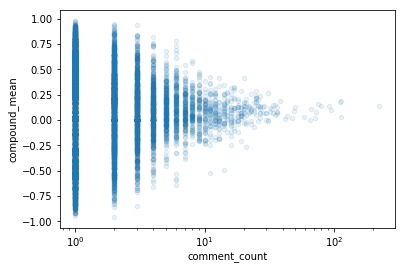

In [11]:
nba_df.sample(20000).plot.scatter('comment_count', 'compound_mean', alpha =0.1)
plt.xscale('log')

Here we can see that the variance of the sentiment estimate goes down as the number of comments goes up. We'll come back to this in a minute when we talk about weighting our regression.

### Simple regression model: unweighted, unclustered

Now we're ready to do some modeling. First, let's see if PPG is predictive of sentiment. To run our regression models, we'll use `statsmodels`'s `wls` function, and use the `formula` parameter to specify our regression. The formula parameter allows us to specify our regression like a mathematical formula, in the form of a string, and is borrowed from R. Here we are targeting our sentiment measure, `compound_mean`, and saying it is linearly related to a combination of minutes played (MP), and points per game (PPG). Once we have specified the model, we run `fit()`, and get some results!

In [4]:
model = smf.wls( formula = 'compound_mean ~ MP + PPG',
                 data = nba_df,
                 weights = 1).fit()

In [4]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          compound_mean   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     103.5
Date:                Fri, 01 Mar 2019   Prob (F-statistic):           1.10e-45
Time:                        20:36:54   Log-Likelihood:            -2.6926e+05
No. Observations:              848401   AIC:                         5.385e+05
Df Residuals:                  848398   BIC:                         5.386e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0700      0.001     73.923      0.000       0.068       0.072
MP         -1.125e-06   6.52e-07     -1.726      0.084    -2.4e-06    1.53e-07
PPG            0.0007   6.46e-05     11.124      0.000       0.001       0.001
==============================================================================
Omnibus:                     1033.683   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1157.941
Skew:                          -0.044   Prob(JB):                    3.60e-252
Kurtosis:                       3.159   Cond. No.                     5.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

To interpret the results of our regression, we're going to look at two values for our features, their coefficient, and the t-statistics. For minutes played, we find the coefficient is ~1e-6, or approximately zero. This means that sentiment does not vary much with minutes played. Furthermore, we find the t-statistic is -1.726. For t-statistics, you want the value to be different from zero. For a 95% confidence interval we want the t-statistic to be > 1.96 or < -1.96 (two standard errors).

In contrast to minutes played, the PPG feature has a non-zero coefficient (0.0007), and a t-statistic of 11.1. This means that scoring points is positively (but weakly) correlated with sentiment, and the magnitude of the t-statistic means we are confident that the coefficient is different from 0.

Of less importance to us is how much of the variance is explained by the model. Our model is not going to be able to explain much of the variance with only two coefficients, especially since many comments are neutral. That is why the R^2 value is basically 0. We can also compare the coefficient of PPG to the standard deviation of sentiment. The standard deviation is around 0.05, which means 1 PPG is worth around 0.01 standard deviations. While it's a little disappointing to see such a low coefficient, it is still meaningful.

### Adding more features

Now that we have a sense of how to interpret coefficients, we can add more covariates. In our blog post, we show multiple specifications with increasing numbers of features. Here let's focus on our full model with all the features (all performance data scraped from [basketball-reference](http://basketball-reference.com):

* ThreePP: Three point percentage
* DWS: Defensive win share (not a rate)
* FTr: Free throw rate; hopefully a proxy for driving to the hoop
* ASTP: Assist percentage
* BLKP: Block percentage
* STLP: Steal percentage
* TOVP: Turnover percentage
* height_dummies: Dummy variables for short, medium, and tall players (NNN What are definitions?)
* rookie: whether player was in rookie year
* youth: number of years below average age (minimum 0)
* oldness: number of years above average age (minimum 0)
* Wins: team wins
* team_math: Boolean representing whether commenter had flair for team of player she was commenting on
* C(Race): boolean variable for race of player
* demean_clinton: Clinton vote percentage - Trump vote percentage for the city from the user's flair (centered around zero for interaction)
* total_population: total population of commenter's city
* demean_PPG: Points per game with mean subtracted for interaction

In [8]:
user_model = smf.wls( formula = 'compound_mean ~ MP + ThreePP + DWS + TRBP + FTr + ASTP + BLKP + STLP + TOVP' \
                           ' + C(height_dummies) + rookie + youth + oldness + Wins + ' \
                           'team_match + C(Race) * demean_clinton +total_population + C(Race) * demean_PPG',
                data = nba_df,
               weights = 1 
               ).fit()

In [9]:
user_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          compound_mean   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     55.70
Date:                Mon, 01 Apr 2019   Prob (F-statistic):          2.62e-245
Time:                        20:00:32   Log-Likelihood:            -2.3957e+05
No. Observations:              758575   AIC:                         4.792e+05
Df Residuals:                  758552   BIC:                         4.795e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.0866      0.004     22.578      0.000       0.079       0.094
C(height_dummies)[T.short]      0.0061      0.002      2.824      0.005       0.002       0.010
C(height_dummies)[T.tall]     4.16e-05      0.001      0.037      0.970      -0.002       0.002
rookie[T.True]                  0.0205      0.002     12.878      0.000       0.017       0.024
team_match[T.True]              0.0042      0.001      4.521      0.000       0.002       0.006
C(Race)[T.W]                    0.0072      0.002      4.792      0.000       0.004       0.010
MP                          -4.747e-06   1.04e-06     -4.581      0.000   -6.78e-06   -2.72e-06
ThreePP                         0.0080      0.004      2.225      0.026       0.001       0.015
DWS                             0.0017      0.001      2.551      0.011       0.000       0.003
TRBP                           -0.0005      0.000     -3.312      0.001      -0.001      -0.000
FTr                            -0.0132      0.003     -4.293      0.000      -0.019      -0.007
ASTP                           -0.0002   5.72e-05     -3.206      0.001      -0.000   -7.13e-05
BLKP                            0.0008      0.000      2.116      0.034    5.65e-05       0.001
STLP                            0.0021      0.001      3.172      0.002       0.001       0.003
TOVP                           -0.0003      0.000     -2.386      0.017      -0.001   -5.01e-05
youth                           0.0023      0.000      8.922      0.000       0.002       0.003
oldness                         0.0012      0.000      7.159      0.000       0.001       0.002
Wins                        -6.033e-05   3.87e-05     -1.558      0.119      -0.000    1.56e-05
demean_clinton                  0.0077      0.003      3.043      0.002       0.003       0.013
C(Race)[T.W]:demean_clinton    -0.0022      0.005     -0.416      0.678      -0.013       0.008
total_population            -1.179e-10   9.45e-11     -1.248      0.212   -3.03e-10    6.73e-11
demean_PPG                      0.0013      0.000     12.670      0.000       0.001       0.001
C(Race)[T.W]:demean_PPG         0.0014      0.000      7.107      0.000       0.001       0.002
==============================================================================
Omnibus:                      936.893   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1054.433
Skew:                          -0.043   Prob(JB):                    1.08e-229
Kurtosis:                       3.162   Cond. No.                     1.10e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The co

In our full model, almost all our coefficients are significant! However, we need to take a moment and think about what our model actually is. In our model, we are treating every user-player pair as equally important, which isn't necessarily true; for example, we have a much better (lower variance) estimate of user-player sentiment for users that comment more. And second, we have multiple observations for each player. In our current model we are treating these observations independently, when they are inextricably linked. We can try to correct for these two problems by performing weighting to handle different comment counts; and using clustered errors to handle the multiple observations for each player.

### Choosing weighting

In our initial model, we weighted each user-player-season equally (note `weights = 1`). However, we already know that the variance of low-comment pairs is higher than high-comment pairs. To handle this, we can weight our data. How do we choose our weights? One way would be to weight each sample by the comment count, as if all commenter-player pairs come from the same distribution (`weights = nba_df['comment_count']`). This effectively weights each sample by its inverse variance, since: $var(y) = \sigma^2 / n$

In [10]:
comment_model = smf.wls( formula = 'compound_mean ~ MP + ThreePP + DWS + TRBP + FTr + ASTP + BLKP + STLP' \
                           '+ TOVP  + C(height_dummies) + rookie + youth + oldness + Wins + ' \
                           'team_match + C(Race) * demean_clinton +total_population + C(Race) * demean_PPG',
                data = nba_df,
               weights = nba_df['comment_count']
               ).fit()

In [11]:
comment_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          compound_mean   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     83.82
Date:                Mon, 01 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:00:39   Log-Likelihood:            -2.2538e+05
No. Observations:              758575   AIC:                         4.508e+05
Df Residuals:                  758552   BIC:                         4.511e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.0845      0.003     24.947      0.000       0.078       0.091
C(height_dummies)[T.short]      0.0095      0.002      4.990      0.000       0.006       0.013
C(height_dummies)[T.tall]      -0.0009      0.001     -0.952      0.341      -0.003       0.001
rookie[T.True]                  0.0208      0.001     14.444      0.000       0.018       0.024
team_match[T.True]             -0.0002      0.001     -0.246      0.806      -0.002       0.001
C(Race)[T.W]                    0.0086      0.001      6.419      0.000       0.006       0.011
MP                          -5.729e-06   8.96e-07     -6.392      0.000   -7.49e-06   -3.97e-06
ThreePP                         0.0078      0.003      2.371      0.018       0.001       0.014
DWS                             0.0015      0.001      2.556      0.011       0.000       0.003
TRBP                           -0.0004      0.000     -2.786      0.005      -0.001      -0.000
FTr                            -0.0118      0.003     -4.125      0.000      -0.017      -0.006
ASTP                           -0.0002   4.93e-05     -3.435      0.001      -0.000   -7.28e-05
BLKP                            0.0005      0.000      1.408      0.159      -0.000       0.001
STLP                            0.0025      0.001      4.183      0.000       0.001       0.004
TOVP                           -0.0003      0.000     -3.088      0.002      -0.001      -0.000
youth                           0.0028      0.000     11.905      0.000       0.002       0.003
oldness                         0.0012      0.000      8.199      0.000       0.001       0.001
Wins                         7.579e-05   3.43e-05      2.212      0.027    8.65e-06       0.000
demean_clinton                  0.0115      0.002      5.526      0.000       0.007       0.016
C(Race)[T.W]:demean_clinton    -0.0099      0.005     -2.100      0.036      -0.019      -0.001
total_population            -2.396e-10   8.01e-11     -2.990      0.003   -3.97e-10   -8.25e-11
demean_PPG                      0.0015   8.83e-05     16.863      0.000       0.001       0.002
C(Race)[T.W]:demean_PPG         0.0016      0.000      8.955      0.000       0.001       0.002
==============================================================================
Omnibus:                     2614.868   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3447.982
Skew:                          -0.036   Prob(JB):                         0.00
Kurtosis:                       3.323   Cond. No.                     1.15e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The co

After weighting, all of our coefficients have changed a bit! We can compare the coefficient magnitudes using the different weights by plotting them.

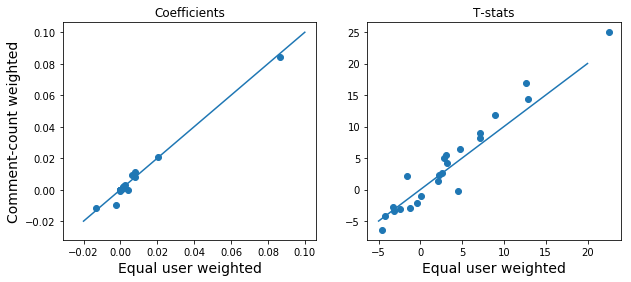

In [19]:
import matplotlib.pyplot as plt
fig, (ax1, ax2)= plt.subplots(1,2, figsize = [10, 4])
fs = 14
ax1.scatter(user_model.params, comment_model.params)
ax1.plot([-0.02, 0.1], [-0.02, 0.1]);
ax1.set_ylabel('Comment-count weighted', fontsize = fs)
ax1.set_xlabel('Equal user weighted', fontsize = fs);
ax1.set_title('Coefficients')
ax2.scatter(user_model.tvalues, comment_model.tvalues)
ax2.plot([-5, 20], [-5, 20])
ax2.set_xlabel('Equal user weighted', fontsize = fs);
ax2.set_title('T-stats');

In general, it looks like the coefficients haven't changed that much. Furthermore, the t-statistics haven't changed much either, with only a few coefficients have switched from significant to not-significant.

Weighting by comment count, however, has significant bias towards prolific commenters and popular players. High-comment count users may not reflect the general opinion of people on a forum (even if they reflect the most obvious opinion). And we need to consider all players to get enough samples to understand all our covariates.

As a compromise between even weighting and comment weighting, I prefer using the square root of the comment count as the weight. I don't have a strong numerical reason for this, as it does not minimize variance or anything like that. But it generally gets at what we want to do: give larger weight to samples we have more information about; but not so much that high comment players and users dominate.

In [54]:
sqrt_model = smf.wls( formula = 'compound_mean ~ MP + ThreePP + DWS + TRBP + FTr + ASTP + BLKP + STLP' \
                           '+ TOVP  + C(height_dummies) + rookie + youth + oldness + Wins + ' \
                           'team_match + C(Race) * demean_clinton +total_population + C(Race) * demean_PPG',
                data = nba_df,
               weights = np.sqrt(nba_df['comment_count'])
               ).fit()

In [55]:
sqrt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          compound_mean   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     72.13
Date:                Mon, 01 Apr 2019   Prob (F-statistic):          1.48e-322
Time:                        20:54:36   Log-Likelihood:            -2.4502e+05
No. Observations:              848058   AIC:                         4.901e+05
Df Residuals:                  848035   BIC:                         4.903e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.0871      0.003     24.984      0.000       0.080       0.094
C(height_dummies)[T.short]      0.0071      0.002      3.609      0.000       0.003       0.011
C(height_dummies)[T.tall]       0.0001      0.001      0.116      0.908      -0.002       0.002
rookie[T.True]                  0.0209      0.001     14.282      0.000       0.018       0.024
team_match[T.True]              0.0024      0.001      2.953      0.003       0.001       0.004
C(Race)[T.W]                    0.0078      0.001      5.669      0.000       0.005       0.010
MP                          -5.103e-06   9.33e-07     -5.467      0.000   -6.93e-06   -3.27e-06
ThreePP                         0.0101      0.003      3.055      0.002       0.004       0.017
DWS                             0.0020      0.001      3.283      0.001       0.001       0.003
TRBP                           -0.0004      0.000     -3.239      0.001      -0.001      -0.000
FTr                            -0.0120      0.003     -4.196      0.000      -0.018      -0.006
ASTP                           -0.0002   5.13e-05     -4.095      0.000      -0.000      -0.000
BLKP                            0.0005      0.000      1.389      0.165      -0.000       0.001
STLP                            0.0027      0.001      4.345      0.000       0.001       0.004
TOVP                           -0.0003      0.000     -3.156      0.002      -0.001      -0.000
youth                           0.0024      0.000      9.881      0.000       0.002       0.003
oldness                         0.0012      0.000      8.280      0.000       0.001       0.002
Wins                        -4.929e-05   3.51e-05     -1.403      0.160      -0.000    1.95e-05
demean_clinton                  0.0094      0.002      3.972      0.000       0.005       0.014
C(Race)[T.W]:demean_clinton    -0.0048      0.005     -0.941      0.347      -0.015       0.005
total_population            -1.833e-10   8.92e-11     -2.054      0.040   -3.58e-10    -8.4e-12
demean_PPG                      0.0014   9.17e-05     14.805      0.000       0.001       0.002
C(Race)[T.W]:demean_PPG         0.0016      0.000      8.704      0.000       0.001       0.002
==============================================================================
Omnibus:                      260.003   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.743
Skew:                          -0.039   Prob(JB):                     1.46e-57
Kurtosis:                       3.036   Cond. No.                     1.15e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The co

#### Comparing the models residuals
To compare these models, we can look at the residuals. If any model better minimizes square error, we would expect its residuals to be smaller. We can look at this by plotting how the mean square error varies with comment count.

First, we calculate the residuals from each model.

In [56]:
nba_df['even_residual'] = user_model.predict(nba_df) - nba_df['compound_mean']
nba_df['linear_residual'] = comment_model.predict(nba_df) - nba_df['compound_mean']
nba_df['sqrt_residual'] = sqrt_model.predict(nba_df) - nba_df['compound_mean']

Then we calculate the squared residuals, and calculate the mean for each comment count number.

In [57]:
def calc_mse_comment_count(df, RESIDUAL_COL):
    df['square_error'] = np.square(df[RESIDUAL_COL])
    return df.groupby('comment_count')['square_error'].mean()

In [58]:
even_mse = calc_mse_comment_count(nba_df, 'even_residual')
linear_mse = calc_mse_comment_count(nba_df, 'linear_residual')
sqrt_mse = calc_mse_comment_count(nba_df, 'sqrt_residual')

Finally, we can plot the MSE in each bucket versus the number of comments. I have also plotted the theoretical 1 / comment count line, which one would expect for reduction in variance with comment count.

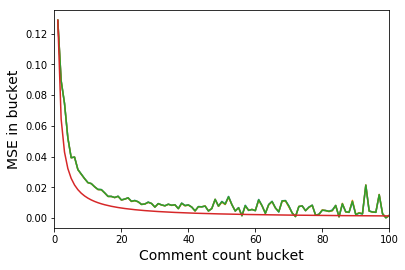

In [59]:
plt.plot(even_mse)
plt.plot(linear_mse)
plt.plot(sqrt_mse);
plt.plot(range(500), even_mse.iloc[0] * 1 / np.array(range(500)))
plt.xlim([0, 100])
plt.xlabel('Comment count bucket', fontsize = fs)
plt.ylabel('MSE in bucket', fontsize = fs);

It looks like there's only one data line! What's happening here is that all three models are creating similar squared residuals. Here are the actual values from the three models. 

In [60]:
join_df = pd.concat([even_mse, linear_mse, sqrt_mse], axis=1).head()
join_df.columns = ['even_weights', 'comment_weights', 'sqrt_weights']
join_df.head(3)

,even_weights,comment_weights,sqrt_weights
comment_count,,,
1,0.128765,0.128794,0.128773
2,0.089416,0.089426,0.089413
3,0.074707,0.074699,0.074698


Since the results are so similar, and the overall results don't depend too much on the weights, I decided to use square root weights for my shared results.

### Clustering errors

The final problem with our current regression is that all of our observations are not independent. Many users are commenting on many players. Another way to put it is that the errors are correlated between the different comments.

One possible way to account for this would be to include fixed effect parameters: we could create a categorical, one-hot variable for each player in the dataset, and get a coefficient for them (e.g. LeBron might get a coefficient of 0.1 sentiment units for being LeBron). While this may be feasible, I don't think this is well motivated, since I don't think most players are unique enough to get real fixed effects. For example, if an athlete had positive sentiment due to a good twitter account, I'd rather create a feature for that like "number of tweets by them." For clustering by commenters,the problem is even more difficult, as there are thousands of commenters.

Instead of doing these fixed effect models, we can use "clustered standard errors." This method basically tells the regression model that the errors between different rows are correlated. The functional result of clustering is that the variance of our estimate of the coefficients will go up (less statistical power, bigger p-values). We can cluster at the level of the user or the player. Since I matched comments to players as a criterion for inclusion, and because there are far fewer players than commenters, I clustered at the level of the player.

In [51]:
clustered_model = smf.wls( formula = 'compound_mean ~ MP + ThreePP + DWS + TRBP + FTr + ASTP + BLKP + STLP' \
                           '+ TOVP  + C(height_dummies) + rookie + youth + oldness + Wins + ' \
                           'team_match + C(Race) * demean_clinton +total_population + C(Race) * demean_PPG',
                data = nba_df,
               weights = np.sqrt(nba_df['comment_count'])
               ).fit(cov_type='cluster', cov_kwds={'groups' : nba_df['Player']})

In [52]:
clustered_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          compound_mean   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     9.004
Date:                Mon, 01 Apr 2019   Prob (F-statistic):           9.53e-27
Time:                        20:54:20   Log-Likelihood:            -2.4502e+05
No. Observations:              848058   AIC:                         4.901e+05
Df Residuals:                  848035   BIC:                         4.903e+05
Df Model:                          22                                         
Covariance Type:              cluster                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.0871      0.013      6.827      0.000       0.062       0.112
C(height_dummies)[T.short]      0.0071      0.005      1.431      0.152      -0.003       0.017
C(height_dummies)[T.tall]       0.0001      0.004      0.029      0.977      -0.008       0.008
rookie[T.True]                  0.0209      0.004      5.489      0.000       0.013       0.028
team_match[T.True]              0.0024      0.002      1.503      0.133      -0.001       0.006
C(Race)[T.W]                    0.0078      0.005      1.575      0.115      -0.002       0.017
MP                          -5.103e-06   3.35e-06     -1.523      0.128   -1.17e-05    1.46e-06
ThreePP                         0.0101      0.013      0.755      0.450      -0.016       0.036
DWS                             0.0020      0.002      0.860      0.390      -0.003       0.007
TRBP                           -0.0004      0.000     -0.905      0.365      -0.001       0.001
FTr                            -0.0120      0.010     -1.257      0.209      -0.031       0.007
ASTP                           -0.0002      0.000     -1.122      0.262      -0.001       0.000
BLKP                            0.0005      0.001      0.396      0.692      -0.002       0.003
STLP                            0.0027      0.002      1.207      0.228      -0.002       0.007
TOVP                           -0.0003      0.000     -1.017      0.309      -0.001       0.000
youth                           0.0024      0.001      3.067      0.002       0.001       0.004
oldness                         0.0012      0.001      1.750      0.080      -0.000       0.003
Wins                        -4.929e-05      0.000     -0.358      0.720      -0.000       0.000
demean_clinton                  0.0094      0.003      3.110      0.002       0.003       0.015
C(Race)[T.W]:demean_clinton    -0.0048      0.007     -0.667      0.505      -0.019       0.009
total_population            -1.833e-10   1.12e-10     -1.633      0.103   -4.03e-10    3.67e-11
demean_PPG                      0.0014      0.000      3.307      0.001       0.001       0.002
C(Race)[T.W]:demean_PPG         0.0016      0.001      2.632      0.008       0.000       0.003
==============================================================================
Omnibus:                      260.003   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.743
Skew:                          -0.039   Prob(JB):                     1.46e-57
Kurtosis:                       3.036   Cond. No.                     1.15e+08
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 1.15

Whereas before, a majority of the coefficients were significant, now only a handful are (for example, rookie, youth, Clinton voting, PPG). While this might be disappointing, we can be more confident that the coefficients reflect reality.

Finally, to show the impact of clustering the errors, we can plot the coefficients and T-stats for the unclustered model versus the clustered model.

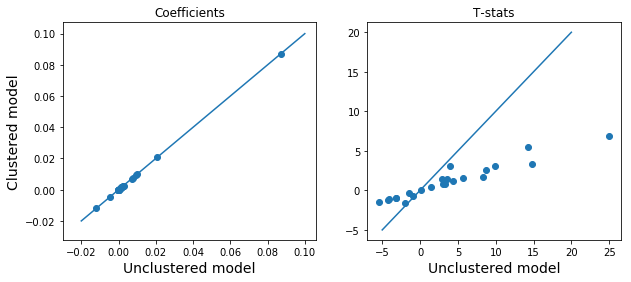

In [61]:
import matplotlib.pyplot as plt
fig, (ax1, ax2)= plt.subplots(1,2, figsize = [10, 4])
fs = 14
ax1.scatter(sqrt_model.params, clustered_model.params )
ax1.plot([-0.02, 0.1], [-0.02, 0.1]);
ax1.set_xlabel('Unclustered model', fontsize = fs);
ax1.set_ylabel('Clustered model', fontsize = fs)
ax1.set_title('Coefficients')
ax2.scatter(sqrt_model.tvalues, clustered_model.tvalues)
ax2.plot([-5, 20], [-5, 20])
ax2.set_xlabel('Unclustered model', fontsize = fs);
ax2.set_title('T-stats');

Perhaps unintuitively, none of the coefficients have changed. This is because the clustering of errors does not impact line of best fit, but rather our estimate of how accurate it is. In contrast, if you look at the t-stats, they are all much smaller than previously, although not uniformly so.

## Conclusion

My process for doing the regression consisted of three main steps:
1. Try different specifications (collections of coefficients) to see understand which coefficient were important.
2. Weight the observations based on our knowledge of the sampling; and verifying that our weighting was not causing problems.
3. Using clustered standard errors to account for the correlation between our observations.

If you thought this notebook was interesting, please do see the [blog post](http://www.trailofpapers.net/2019/02/what-makes-athletes-popular.html) that summarizes the results!